# Microstructure Tutorial

## Acknowledgments

Code Contributors: Mike Durand, HP Marshall, Micah Johnson, Tate Meehan, Megan Mason. Many thanks to Scott Henderson for helping with technical questions!

## Snow Microstructure: Fun Facts

Snow microstructure plays a super important role in snow physics and snow remote sensing, so a lot of effort went towards measuring it in SnowEx 2020!

Because the term "grain size" does not have a precise definition, it's best to refer to "microstructure" instead, but hey, we all slip up sometimes. :)


Snow microstructure  governs response of remote sensing to snow cover for visible, near-infrared and high-frequency microwave wavelengths. See Figure 1, below, and read {cite:p}`Dozier2009`, for more information.

<img src="images/dozier2009_fig2.jpg" width="300">

<b>Figure 1: Snow microstructure governs visible and near-infrared reflectance. This is figure 2 from {cite:p}`Dozier2009`</b>

The Ku-band SWEARR instrument is very sensitive to snow microstructure. 

(Show a graphic of sigma0 vs SWE as a function of grain size)

(talk about need for priors for inversino)

Snow microstructure is controlled by other snow properties, such as snow temperature, snow height and snow liquid water content. 

## SnowEx Microstructure Measurement Background

### Basic Microstructure Definitions

(graphic of CT image)

Specific surface area (SSA)...

Autocorrelation length (L)...

Geometric grain size measurements (D)

### Microstructure Instruments

Micro-computed tomography (microCT)...

Integrating Spheres...

Snow micropenetrometers... Note micropine module used to estimate SSA ... note that SMP includes the raw data... so need to add micropine library... Mike will ask Tate to send a comparison between SMP and SSA.

## SnowEx Microstructure Measurement Data Overview

Number of measurements made by various instruments. Sampling strategy. King's Cross.


## Working with the data

### 1. Load needed modules

In [1]:
# Modules needed to access snowexsql: SnowEx field data database
from snowexsql.db import get_db
from snowexsql.data import LayerData, PointData
from snowexsql.conversions import points_to_geopandas, query_to_geopandas

# Modules needed to work with data
import geoalchemy2.functions as gfunc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

### 2. Import Database

In [2]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Grab all the equivalent diameter profiles
q = session.query(LayerData).filter(LayerData.type == 'specific_surface_area')
#q_smp=session.query(LayerData).filter(LayerData.type == 'force')
df = query_to_geopandas(q, engine)
#df_smp=query_to_geopandas(q_smp, engine)

# End our database session to avoid hanging transactions
session.close()


### 3. Isolate all the Sites with Multiple Integrating Sphere Instruments

In [3]:
# Grab all the sites with equivalent diameter data (set reduces a list to only its unique entries)
sites = df['site_id'].unique()

# Store all site names that have mulitple SSA instruments
multi_instr_sites = []
instruments = []

for site in sites:

    # Grab all the layers associated to this site
    site_data = df.loc[df['site_id'] == site]

    # Do a set on all the instruments used here
    instruments_used = site_data['instrument'].unique()

    if len(instruments_used) > 1:
        multi_instr_sites.append(site)

# Get a unqique list of SSA instruments that were colocated
instruments = df['instrument'].unique()

### 4. Plot all Integrating Sphere SSA profiles at all Multi-Integrating Sphere Sites

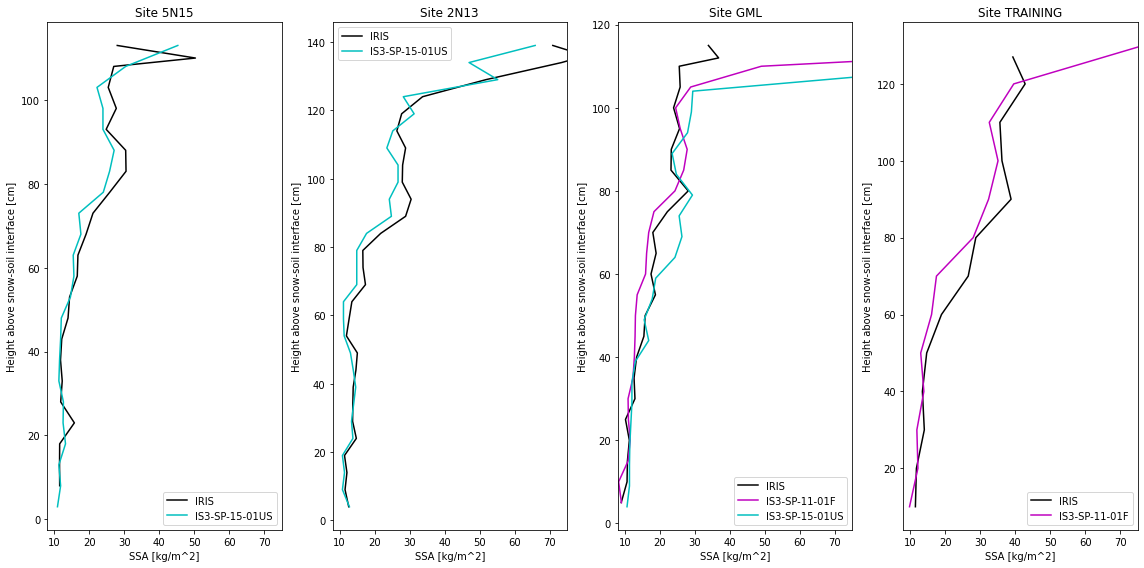

In [4]:
# Setup the subplot for each site for each instrument
fig, axes = plt.subplots(1, len(multi_instr_sites), figsize=(4*len(multi_instr_sites), 8))

# Establish plot colors unique to the instrument
c = ['k', 'm', 'c']
colors = {inst:c[i] for i,inst in enumerate(instruments)}

# Loop over all the multi-instrument sites 
for i, site in enumerate(multi_instr_sites):
    
    # Grab the plot for this site
    ax = axes[i]
    
    # Loop over all the instruments at this site
    for instr in instruments:

        # Grab our profile by site and instrument
        ind = df['site_id'] == site 
        ind2 = df['instrument'] == instr
        profile = df.loc[ind & ind2].copy()

        # Don't plot it unless there is data
        if len(profile.index) > 0:
            
            # Sort by depth so samples that are take out of order won't mess up the plot
            profile = profile.sort_values(by='depth')
            
            # Layer profiles are always stored as strings. 
            profile['value'] = profile['value'].astype(float)
            
            # Plot our profile
            ax.plot(profile['value'], profile['depth'], colors[instr], label=instr)
   
    # Labeling and plot style choices
    ax.legend()
    ax.set_xlabel('SSA [kg/m^2]')
    ax.set_ylabel('Height above snow-soil interface [cm]')
    ax.set_title('Site {}'.format(site.upper()))
    
    # Set the x limits to show more detail
    ax.set_xlim((8, 75))
    
plt.tight_layout()
plt.show()


### 5. Compare integrating sphere with SMP

In [5]:
site = '2N13'
engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)
session_smp.close()

In [16]:
# these are imported from the snowmicropyn modules available at https://github.com/slf-dot-ch/snowmicropyn
# 
import loewe2012 
import proksch2015

/home/jovyan/website/book/tutorials/microstructure/proksch2015.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  from pandas import np as np


In [17]:
proksch2015.calc_step

<function proksch2015.calc_step(median_force, element_size)>

### 6. Compare intergrating sphere, SMP and microCT

## References

Dozier, J., Green, R. O., Nolin, A. W., & Painter, T. H. (2009). Interpretation of snow properties from imaging spectrometry. REMOTE SENSING OF ENVIRONMENT, 113, S25 S37. https://doi.org/10.1016/j.rse.2007.07.029